## Import module

In [1]:
#basic module
import pandas as pd # data processing
import numpy as np # linear algebra
import seaborn as sns
from matplotlib import pyplot as plt
import os
import time
import copy

#data preprocessing
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate
from datasist.structdata import detect_outliers

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Importing Library

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Precision, Recall, F1Score

import lightgbm as lgb

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report, roc_auc_score, roc_curve

start = time.time()

In [2]:
# set GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


In [3]:
os.environ['CUDA_LAUNCH_BLOCKING']= "-1"

#### reference
- Heart Disease Prediction : https://www.kaggle.com/code/omarmohamedyehia/heart-disease-prediction

## Data Check

In [4]:
data = pd.read_csv("heart_2020_cleaned.csv",parse_dates=True, dayfirst=False)

In [5]:
outliers_indices = detect_outliers(data, 0, ['BMI'])
len(outliers_indices)

10396

In [6]:
data.drop(index = outliers_indices, inplace=True)

In [7]:
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319789,No,22.22,No,No,No,0.0,0.0,No,Female,18-24,Hispanic,No,Yes,Excellent,8.0,No,No,No
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No


In [8]:
for feature in data.columns: # feature 별 특징 확인
    print(feature)
    print(data[feature].unique(),"\n")

HeartDisease
['No' 'Yes'] 

BMI
[16.6  20.34 26.58 ... 41.23 15.57 40.7 ] 

Smoking
['Yes' 'No'] 

AlcoholDrinking
['No' 'Yes'] 

Stroke
['No' 'Yes'] 

PhysicalHealth
[ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 18.  8. 25.
 16. 29. 27. 17. 24. 12. 23. 26. 22. 19.  9. 13. 11.] 

MentalHealth
[30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24. 28. 16. 12.  6.
 25. 17.  9. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.] 

DiffWalking
['No' 'Yes'] 

Sex
['Female' 'Male'] 

AgeCategory
['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29'] 

Race
['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic'] 

Diabetic
['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)'] 

PhysicalActivity
['Yes' 'No'] 

GenHealth
['Very good' 'Fair' 'Good' 'Poor' 'Excellent'] 

SleepTime
[ 5.  7.  8.  6. 12.  4.  9. 10. 15.  3.  2.  1. 18. 14. 16. 20. 11. 13.
 17. 24. 19. 21. 22. 23.] 

Asthma
['Yes' 'No'] 


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309399 entries, 0 to 319793
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      309399 non-null  object 
 1   BMI               309399 non-null  float64
 2   Smoking           309399 non-null  object 
 3   AlcoholDrinking   309399 non-null  object 
 4   Stroke            309399 non-null  object 
 5   PhysicalHealth    309399 non-null  float64
 6   MentalHealth      309399 non-null  float64
 7   DiffWalking       309399 non-null  object 
 8   Sex               309399 non-null  object 
 9   AgeCategory       309399 non-null  object 
 10  Race              309399 non-null  object 
 11  Diabetic          309399 non-null  object 
 12  PhysicalActivity  309399 non-null  object 
 13  GenHealth         309399 non-null  object 
 14  SleepTime         309399 non-null  float64
 15  Asthma            309399 non-null  object 
 16  KidneyDisease     30

In [10]:
No_Value = data.HeartDisease.value_counts()[0]
Yes_Value = data.HeartDisease.value_counts()[1]
print("The number of Yes Value has {}%".format(((Yes_Value/len(data))*100)))

The number of Yes Value has 8.464797882346096%


## Data Preprocessing

### Ordinal Encoder

In [11]:
mapping_Genhealth={'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4}
mapping_AgeCategory ={'18-24': 0, '25-29': 1, '30-34': 2, '35-39': 3, '40-44': 4, '45-49': 5, '50-54': 6,
 '55-59': 7, '60-64': 8, '65-69': 9, '70-74': 10, '75-79': 11, '80 or older': 12}
mapping_yes_no={'Yes':1,'No':0}
Yes_No_Columns=['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma',
                'KidneyDisease', 'SkinCancer']

In [12]:
data[Yes_No_Columns]=data[Yes_No_Columns].replace(mapping_yes_no)
data['GenHealth']=data['GenHealth'].map(mapping_Genhealth)
#data['AgeCategory']=data['AgeCategory'].map(mapping_AgeCategory)
data['HeartDisease']=data['HeartDisease'].map(mapping_yes_no)

In [13]:
data_enc = data.copy()

In [14]:
for feature in data_enc.columns:
    print(feature)
    print(data_enc[feature].unique(),"\n")

HeartDisease
[0 1] 

BMI
[16.6  20.34 26.58 ... 41.23 15.57 40.7 ] 

Smoking
[1 0] 

AlcoholDrinking
[0 1] 

Stroke
[0 1] 

PhysicalHealth
[ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 18.  8. 25.
 16. 29. 27. 17. 24. 12. 23. 26. 22. 19.  9. 13. 11.] 

MentalHealth
[30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24. 28. 16. 12.  6.
 25. 17.  9. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.] 

DiffWalking
[0 1] 

Sex
['Female' 'Male'] 

AgeCategory
['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29'] 

Race
['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic'] 

Diabetic
['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)'] 

PhysicalActivity
[1 0] 

GenHealth
[3 1 2 0 4] 

SleepTime
[ 5.  7.  8.  6. 12.  4.  9. 10. 15.  3.  2.  1. 18. 14. 16. 20. 11. 13.
 17. 24. 19. 21. 22. 23.] 

Asthma
[1 0] 

KidneyDisease
[0 1] 

SkinCancer
[1 0] 



### One-Hot Encoding

In [15]:
one_cols =['Sex','Race', 'Diabetic', 'AgeCategory']
data_enc=pd.get_dummies(data_enc,columns=one_cols,drop_first=True).copy()

In [16]:
data_enc

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity,GenHealth,...,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older
0,0,16.60,1,0,0,3.0,30.0,0,1,3,...,0,0,0,0,1,0,0,0,0,0
1,0,20.34,0,0,1,0.0,0.0,0,1,3,...,0,0,0,0,0,0,0,0,0,1
2,0,26.58,1,0,0,20.0,30.0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,2,...,0,0,0,0,0,0,0,0,1,0
4,0,23.71,0,0,0,28.0,0.0,1,1,3,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319789,0,22.22,0,0,0,0.0,0.0,0,1,4,...,0,0,0,0,0,0,0,0,0,0
319790,1,27.41,1,0,0,7.0,0.0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,1,3,...,1,0,0,0,0,0,0,0,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,1,2,...,0,0,1,0,0,0,0,0,0,0


### Data Split

In [17]:
features = data_enc.drop(columns =['HeartDisease'], axis = 1)
target = data_enc['HeartDisease']

In [18]:
X_train_ori, X_test, y_train_ori, y_test = train_test_split(features, target, shuffle = True, test_size = .2, random_state = 44)
X_train_dnn, X_val_dnn, y_train_dnn, y_val_dnn = train_test_split(X_train_ori, y_train_ori, shuffle = True, test_size = 0.125, random_state = 44)

In [19]:
# standardization 적용 부분
enc_col = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'GenHealth']
X_train_std=X_train_dnn[enc_col].copy()
X_val_std=X_val_dnn[enc_col].copy()
X_test_std=X_test[enc_col].copy()

# one hot 된 부분
com_col = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 
           'SkinCancer','Sex_Male', 'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other','Race_White', 
           'Diabetic_No, borderline diabetes', 'Diabetic_Yes','Diabetic_Yes (during pregnancy)', 
           'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39','AgeCategory_40-44', 
           'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59','AgeCategory_60-64', 
           'AgeCategory_65-69', 'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_80 or older',]

X_train_com=X_train_dnn[com_col].copy()
X_val_com=X_val_dnn[com_col].copy()
X_test_com=X_test[com_col].copy()

In [20]:
X_train_com = X_train_com.reset_index(drop=True)
X_val_com = X_val_com.reset_index(drop=True)
X_test_com = X_test_com.reset_index(drop=True)

y_train_dnn = y_train_dnn.reset_index(drop=True)
y_val_dnn = y_val_dnn.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Standard Scaler

In [21]:
stand_scale = MinMaxScaler()
stand_scale.fit(X_train_std)

MinMaxScaler()

In [22]:
X_train_std = stand_scale.transform(X_train_std)
X_val_std = stand_scale.transform(X_val_std)
X_test_std = stand_scale.transform(X_test_std)

In [23]:
X_train_std = pd.DataFrame(X_train_std , columns = enc_col)
X_val_std = pd.DataFrame(X_val_std  , columns = enc_col)
X_test_std = pd.DataFrame(X_test_std  , columns = enc_col)

In [24]:
X_train = pd.merge(X_train_std, X_train_com,left_index=True, right_index=True)
X_val = pd.merge(X_val_std, X_val_com,left_index=True, right_index=True)
X_test = pd.merge(X_test_std, X_test_com,left_index=True, right_index=True)

In [25]:
X_train

,BMI,PhysicalHealth,MentalHealth,SleepTime,GenHealth,Smoking,AlcoholDrinking,Stroke,DiffWalking,PhysicalActivity,...,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older
0,0.405020,0.333333,0.000000,0.260870,0.25,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.455563,0.000000,0.000000,0.217391,0.75,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0.475916,0.066667,0.033333,0.304348,0.75,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0.265604,0.000000,0.000000,0.304348,1.00,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.259837,0.000000,0.000000,0.260870,1.00,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216574,0.778155,1.000000,1.000000,0.173913,0.00,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
216575,0.546472,0.500000,0.000000,0.217391,0.50,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
216576,0.271370,0.000000,0.000000,0.391304,0.25,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
216577,0.364993,0.000000,0.033333,0.304348,0.75,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [26]:
print('Shape of training feature:', X_train.shape)
print('Shape of validation feature:', X_val.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of y_train label:', y_train_dnn.shape)
print('Shape of y_val label:', y_val_dnn.shape)
print('Shape of y_test label:', y_test.shape)

Shape of training feature: (216579, 34)
Shape of validation feature: (30940, 34)
Shape of testing feature: (61880, 34)
Shape of y_train label: (216579,)
Shape of y_val label: (30940,)
Shape of y_test label: (61880,)


### (선택)Dataset 저장용

#### SMOTETomek 적용 전

In [258]:
train = pd.merge(y_train_dnn, X_train,left_index=True, right_index=True).copy()
val = pd.merge(y_val_dnn, X_val,left_index=True, right_index=True).copy()
test = pd.merge(y_test, X_test,left_index=True, right_index=True).copy()

In [259]:
train

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,GenHealth,Smoking,AlcoholDrinking,Stroke,DiffWalking,...,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older
0,0,0.405020,0.333333,0.000000,0.260870,0.25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0.455563,0.000000,0.000000,0.217391,0.75,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0.475916,0.066667,0.033333,0.304348,0.75,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.265604,0.000000,0.000000,0.304348,1.00,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0.259837,0.000000,0.000000,0.260870,1.00,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216574,0,0.778155,1.000000,1.000000,0.173913,0.00,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
216575,0,0.546472,0.500000,0.000000,0.217391,0.50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
216576,0,0.271370,0.000000,0.000000,0.391304,0.25,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
216577,0,0.364993,0.000000,0.033333,0.304348,0.75,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [188]:
# 저장
train.to_csv('train_SMOTE_not.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

#### SMOTETomek 적용 후

In [27]:
smt = SMOTETomek(random_state=42)

In [28]:
%%time
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(X_train, y_train_dnn)

CPU times: user 1h 39min 47s, sys: 36min 23s, total: 2h 16min 11s
Wall time: 34min 2s


In [322]:
X_train_SMOTE = pd.read_csv("X_train_SMOTE.csv",parse_dates=True, dayfirst=False)
y_train_SMOTE = pd.read_csv("y_train_SMOTE.csv",parse_dates=True, dayfirst=False)

In [34]:
X_train_SMOTE.to_csv('X_train_SMOTE.csv', index=False)
y_train_SMOTE.to_csv('y_train_SMOTE.csv', index=False)

In [645]:
train_SMOTE = pd.merge(y_train_SMOTE, X_train_SMOTE,left_index=True, right_index=True).copy()

In [647]:
train_SMOTE.to_csv('train_SMOTE.csv', index=False)

In [307]:
train_SMOTE = train_SMOTE.sample(frac=1).reset_index(drop=True)

In [308]:
X_train_SMOTE_nnn = train_SMOTE.iloc[:,1:]
y_train_SMOTE_nnn = train_SMOTE.iloc[:,:1]

In [70]:
y_train_SMOTE_nnn = y_train_SMOTE_nnn['HeartDisease']

In [323]:
X_train_SMOTE

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking,AlcoholDrinking,Stroke,DiffWalking,PhysicalActivity,Asthma,...,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,-0.519077,0.867127,-0.483098,-0.073567,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
1,-0.232960,-0.415075,-0.483098,-0.774534,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.117745,-0.158635,-0.355523,0.627401,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,-1.308300,-0.415075,-0.483098,0.627401,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,-1.340944,-0.415075,-0.483098,-0.073567,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389685,1.818374,-0.415075,-0.483098,-1.657714,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
389686,-0.762675,-0.294389,-0.363019,1.328369,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
389687,1.186200,-0.415075,-0.483098,-0.480204,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
389688,-1.068416,2.953172,3.344161,-0.774534,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [40]:
train_SMOTE = pd.merge(y_train_SMOTE, X_train_SMOTE,left_index=True, right_index=True).copy()

In [41]:
train_SMOTE 

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking,AlcoholDrinking,Stroke,DiffWalking,PhysicalActivity,...,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0,-0.519077,0.867127,-0.483098,-0.073567,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
1,0,-0.232960,-0.415075,-0.483098,-0.774534,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,-0.117745,-0.158635,-0.355523,0.627401,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
3,0,-1.308300,-0.415075,-0.483098,0.627401,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,-1.340944,-0.415075,-0.483098,-0.073567,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389685,1,1.818374,-0.415075,-0.483098,-1.657714,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
389686,1,-0.762675,-0.294389,-0.363019,1.328369,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
389687,1,1.186200,-0.415075,-0.483098,-0.480204,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
389688,1,-1.068416,2.953172,3.344161,-0.774534,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

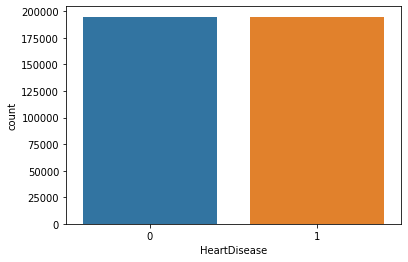

In [33]:
sns.countplot(x="HeartDisease", data=train_SMOTE)

In [42]:
# 저장
train_SMOTE.to_csv('train_SMOTE.csv', index=False)

### Correlation Find

In [89]:
train.columns

Index(['HeartDisease', 'BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime',
       'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex_Male',
       'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'GenHealth_Fair',
       'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good'],
      dtype='object')

In [1208]:
from sklearn.metrics import matthews_corrcoef

cols = train_SMOTE.columns
corr = []

for col in cols:
    if col in com_col:
        corr.append(matthews_corrcoef(train_SMOTE['HeartDisease'], train_SMOTE[col]))
    else:
        corr.append(train_SMOTE['HeartDisease'].corr(train_SMOTE[col]))


correlation = pd.DataFrame(list(zip(cols, corr)), columns=['Variables','Corr_with_HeartDisease'])

correlation.drop(index=correlation.index[:1], axis=0, inplace=True)


correlation

,Variables,Corr_with_HeartDisease
1,BMI,0.097831
2,PhysicalHealth,0.237146
3,MentalHealth,0.016971
4,SleepTime,0.014958
5,GenHealth,-0.418580
6,Smoking,0.186697
7,AlcoholDrinking,-0.113450
8,Stroke,0.196691
9,DiffWalking,0.281686
10,PhysicalActivity,-0.184036


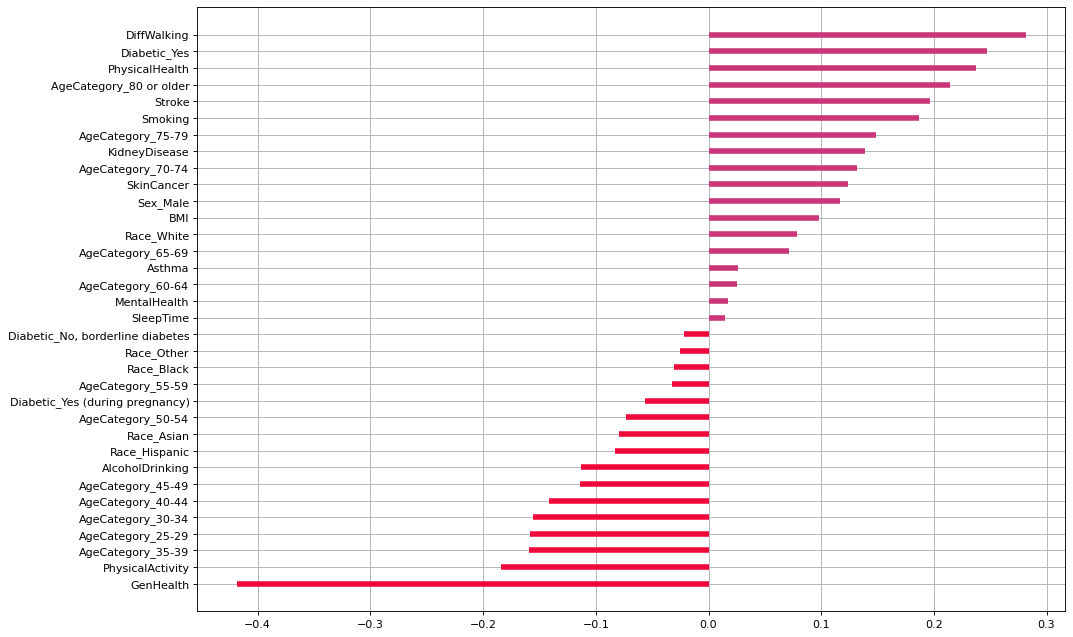

In [1209]:
for i in range(len(correlation)):
    # Colour of bar chart is set to red if corr is < 0 and green otherwise
    correlation['colors'] = ['#F0073B' if float(x) <= 0 else '#CB3579' for x in correlation['Corr_with_HeartDisease']]

correlation = correlation.sort_values(ascending=True, by=['Corr_with_HeartDisease']) 

plt.figure(figsize=(14,10), dpi=80)

plt.hlines(y=correlation.Variables, xmin=0, xmax=correlation.Corr_with_HeartDisease, color=correlation.colors,  linewidth=5)

plt.grid()
plt.show()

In [94]:
from yellowbrick.features import PCA as yellowPCA

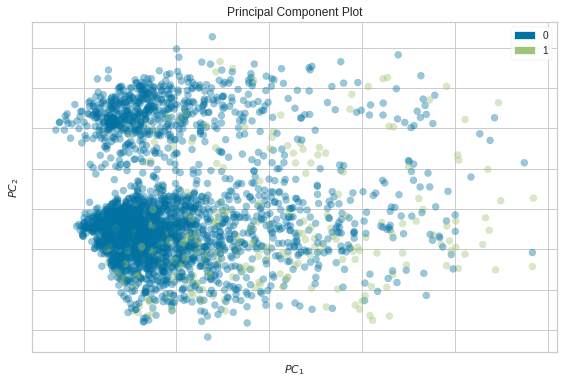

In [95]:
def pca_visualisation_2d(df_temp : pd.DataFrame, target_col : str) -> None:
    """
    Visualize 2d
    
    Parameters
    ----------
    df_temp : pd.DataFrame
        The dataframe to use features from for embedding
    target_col : str
        The target variable to be dropped from dataframe
    """
    if len(df_temp) > 3000:
        df_temp = df_temp.copy().sample(n=2999, random_state=1)
    y = df_temp[target_col]
    X = df_temp.drop(columns=[target_col])
    visualizer = yellowPCA(scale=True, projection=2, alpha=0.4)
    visualizer.fit_transform(X, y)
    visualizer.show()
    plt.show()

pca_visualisation_2d(train, "HeartDisease")

## Modeling

### Random forest

In [301]:
# 평가 함수
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
#    f1 = f1_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='weighted')
    cr = classification_report(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    fpr, tpr, thres = roc_curve(y_test, pred)
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy:{}, Precision:{}, recall:{}, F1-score:{}'.format(accuracy, precision, recall, f1))
    print(cr)
    print('AUC:{}'.format(auc))
    plot_roc_curve(fpr,tpr)
    plt.show

In [302]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

In [313]:
X_train_SMOTE_non = X_train_SMOTE_nnn.dropna()
y_train_SMOTE_non = y_train_SMOTE_nnn.dropna()

In [319]:
X_train_SMOTE_nnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312645 entries, 0 to 312644
Data columns (total 37 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   BMI                               312645 non-null  float64
 1   PhysicalHealth                    312645 non-null  float64
 2   MentalHealth                      312644 non-null  float64
 3   SleepTime                         312644 non-null  float64
 4   Smoking                           312644 non-null  float64
 5   AlcoholDrinking                   312644 non-null  float64
 6   Stroke                            312644 non-null  float64
 7   DiffWalking                       312644 non-null  float64
 8   PhysicalActivity                  312644 non-null  float64
 9   Asthma                            312644 non-null  float64
 10  KidneyDisease                     312644 non-null  float64
 11  SkinCancer                        312644 non-null  f

In [314]:
X_train_SMOTE_non

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking,AlcoholDrinking,Stroke,DiffWalking,PhysicalActivity,Asthma,...,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0.335434,-0.415075,0.409929,0.627401,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.215677,3.431531,-0.483098,-0.774534,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.027943,-0.415075,-0.483098,-0.073567,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.207996,-0.415075,-0.227948,0.627401,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.367377,-0.415075,-0.483098,-0.073567,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312640,0.702202,-0.415075,-0.100373,0.627401,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
312641,0.798215,-0.415075,0.537504,-0.774534,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
312642,-0.893526,-0.415075,0.792655,-0.073567,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
312643,0.853902,-0.415075,-0.483098,-0.073567,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [315]:
%%time
from sklearn.ensemble import RandomForestClassifier

#모델 훈련
rand_clf = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=28, random_state=0)
rand_clf.fit(X_train_SMOTE_non, y_train_SMOTE_non)

y_pred_train = rand_clf.predict(X_train_SMOTE_non)

ValueError: Found input variables with inconsistent numbers of samples: [312644, 312645]

Confusion Matrix
[[56492    64]
 [ 5201   123]]
Accuracy:0.9149159663865546, Precision:0.6577540106951871, recall:0.023102930127723516, F1-score:0.8771091525436793
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56556
           1       0.66      0.02      0.04      5324

    accuracy                           0.91     61880
   macro avg       0.79      0.51      0.50     61880
weighted avg       0.89      0.91      0.88     61880

AUC:0.5109856541861476


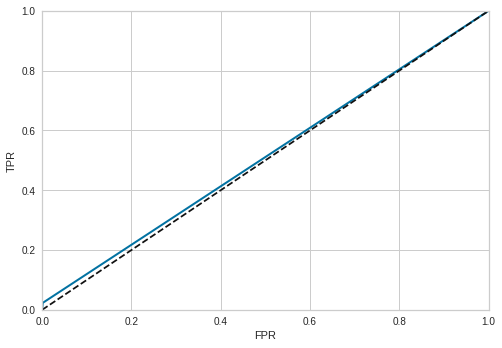

In [305]:
#test set으로 검증
y_randfore_pred_test = rand_clf.predict(X_test)
get_clf_eval(y_test, y_randfore_pred_test)

### DNN

In [260]:
USE_CUDA = torch.cuda.is_available()
torch.cuda.is_available()

True

In [261]:
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cuda


<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

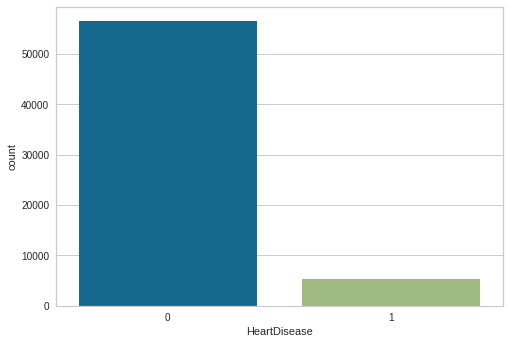

In [262]:
sns.countplot(x="HeartDisease", data=test)

In [263]:
No_Value_test = test.HeartDisease.value_counts()[0]
Yes_Value_test = test.HeartDisease.value_counts()[1]
print("The number of Yes Value has {}%".format(((Yes_Value_test/len(test))*100).round(2)))

The number of Yes Value has 8.6%


In [489]:
"""
torch Variable에는 3개의 형태가 있다. 
data, grad, grad_fn 한 번 구글에 찾아서 공부해보길 바랍니다. 
"""
X_train_SMOTE_DNN = torch.Tensor(X_train_SMOTE.values)
X_val_DNN = torch.Tensor(X_val.values)
X_test_DNN = torch.Tensor(X_test.values)

y_train_SMOTE_DNN = torch.Tensor(y_train_SMOTE.values)
y_val_DNN = torch.Tensor(y_val_dnn.values)
y_test_DNN = torch.Tensor(y_test.values)

In [490]:
X_train_SMOTE_DNN_final = torch.reshape(X_train_SMOTE_DNN,   (X_train_SMOTE_DNN.shape[0], X_train_SMOTE_DNN.shape[1]))
X_val_DNN_final = torch.reshape(X_val_DNN,  (X_val_DNN.shape[0], X_val_DNN.shape[1]))
X_test_DNN_final = torch.reshape(X_test_DNN,  (X_test_DNN.shape[0], X_test_DNN.shape[1]))

In [491]:
y_train_SMOTE_DNN = torch.reshape(y_train_SMOTE_DNN,  (y_train_SMOTE_DNN.shape[0],))
y_train_SMOTE_DNN = y_train_SMOTE_DNN.unsqueeze(-1)
y_val_DNN = y_val_DNN.unsqueeze(-1)
y_test_DNN = y_test_DNN.unsqueeze(-1)

In [492]:
y_val_DNN

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [493]:
print("Training Shape", X_train_SMOTE_DNN_final.shape, y_train_SMOTE_DNN.shape)
print("val Shape", X_val_DNN_final.shape, y_val_DNN.shape) 
print("Testing Shape", X_test_DNN_final.shape, y_test_DNN.shape) 

Training Shape torch.Size([387056, 34]) torch.Size([387056, 1])
val Shape torch.Size([30940, 34]) torch.Size([30940, 1])
Testing Shape torch.Size([61880, 34]) torch.Size([61880, 1])


In [584]:
train_data_DNN = torch.utils.data.TensorDataset(X_train_SMOTE_DNN_final, y_train_SMOTE_DNN)
val_data_DNN = torch.utils.data.TensorDataset(X_val_DNN_final, y_val_DNN)
test_data_DNN = torch.utils.data.TensorDataset(X_test_DNN_final, y_test_DNN)

In [1198]:
train_loader = DataLoader(dataset=train_data_DNN, batch_size=2048, shuffle=True, num_workers=12, persistent_workers=True)
val_loader = DataLoader(dataset=val_data_DNN, batch_size=2048, shuffle=True, num_workers=12, persistent_workers=True)
test_loader = DataLoader(dataset=test_data_DNN, batch_size=2048, shuffle=True, num_workers=12, persistent_workers=True)

In [41]:
# Set Hyper parameters and other variables to train the model.
epochs = 10
#lr = 0.01
momentum = 0.5
log_interval = 200

In [42]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.4):
        super(FocalLoss, self).__init__()
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = self.loss_fn.reduction  # mean, sum, etc..

    def forward(self, pred, true):
        bceloss = self.loss_fn(pred, true)

        pred_prob = torch.sigmoid(pred)  # p  pt는 p가 true 이면 pt = p / false 이면 pt = 1 - p
        alpha_factor = true * self.alpha + (1-true) * (1 - self.alpha)  # add balance
        modulating_factor = torch.abs(true - pred_prob) ** self.gamma  # focal term
        loss = alpha_factor * modulating_factor * bceloss  # bceloss에 이미 음수가 들어가 있음

        if self.reduction == 'mean':
            return loss.mean()
        
        elif self.reduction == 'sum':
            return loss.sum()
        
        else:  # 'none'
            return loss

In [43]:
#FL = FocalLoss()
BE = nn.BCEWithLogitsLoss(pos_weight)

criterion = FL

# optimizer = optim.Adam(net.parameters(), lr=0.0001)
optimizer = optim.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(epochs * 0.5), int(epochs * 0.75)], gamma=0.1, last_epoch=-1)

NameError: name 'pos_weight' is not defined

In [44]:
#### 모델 정의
class Net(nn.Module): # 신경망 모듈 상속받는 파이썬 클래스 정의
    def __init__(self, input_size, hidden_size): # 객체 생성 시 자동 호출 되는 init 함수
        super(Net, self).__init__() # Net 클래스가 nn.Module의 속성을 갖고 초기화
        self.input_size = input_size # 입력 데이터의 차원
        self.hidden_size = hidden_size # linear layer 내 은닉 유닛 개수
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU() # activation function ReLU 선언
        self.fc2 = nn.Linear(self.hidden_size, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, x):
        linear1 = self.fc1(x)
        batch1 = self.batchnorm1(linear1)
        relu1 = self.relu(batch1)
        drop1 = self.dropout(relu1)
        batch1 = self.batchnorm1(drop1)
        linear2 = self.fc2(batch1)
        batch2 = self.batchnorm2(linear2)
        relu2 = self.relu(batch2)
        linear3 = self.fc3(relu2)
        relu3 = self.relu(linear3)
        drop2 = self.dropout(relu3)
        linear4 = self.fc4(drop2)
        
        output = linear4
        
        return output

In [45]:
print("init model done")
net = Net(input_size = 34, hidden_size = 64).to(device)
print(net)

init model done
Net(
  (fc1): Linear(in_features=34, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [46]:
pos_weight = (y_test_DNN==0.).sum()/len(y_test_DNN)
pos_weight

NameError: name 'y_test_DNN' is not defined

In [47]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [48]:
%%time

min_valid_loss = np.inf
for e in range(epochs + 1):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_precision = 0
    epoch_recall = 0
    
    net.train()     # Optional when not using Model Specific layer
    for i, (X, y_batch) in enumerate(train_loader):
        X, y_batch = X.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = net(X)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        #macro_f1 = f1_score(y_pred, y_batch, average='macro')
        #precision = pre(y_pred, y_batch)
        #recall = rec(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #epoch_f1 += macro_f1.item()
        #epoch_recall += recall.item()
        #epoch_precision += precision.item()
    
    valid_loss = 0.0
    val_epoch_acc = 0.0
    net.eval()     # Optional when not using Model Specific layer
    for i, (X, y_batch) in enumerate(val_loader):
        X, y_batch = X.to(device), y_batch.to(device)
        
        y_pred = net(X)
        loss = criterion(y_pred,y_batch)
        val_acc = binary_acc(y_pred, y_batch)
        
        valid_loss = loss.item() * X.size(0)
        val_epoch_acc += val_acc.item()

    print(f'Epoch {e+1} | Train Loss: {epoch_loss / len(train_loader)} | Train acc : {epoch_acc/ len(train_loader)} | Train f1 : {epoch_f1/ len(train_loader)} | Val Loss: {valid_loss / len(val_loader)} | Val acc : {val_epoch_acc/len(val_loader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(net.state_dict(), 'saved_model.pth')

NameError: name 'train_loader' is not defined

In [1201]:
y_pred_list = []
net.eval()
with torch.no_grad():
    for i, (X_batch, y) in enumerate(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = net(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        #y_pred_list.append(y_test_pred.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [1202]:
y_pred_list = sum(y_pred_list, [])

In [1203]:
y_pred_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [1204]:
y_test_DNN

tensor([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [1205]:
print(classification_report(y_test_DNN, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     56556
         1.0       0.08      0.03      0.04      5324

    accuracy                           0.89     61880
   macro avg       0.50      0.50      0.49     61880
weighted avg       0.84      0.89      0.86     61880



In [1103]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

AUC:0.4996845476826118


<function matplotlib.pyplot.show(close=None, block=None)>

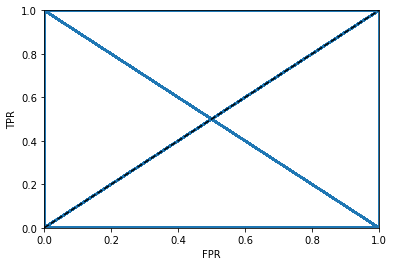

In [1104]:
auc = roc_auc_score(y_test_DNN, y_pred_list)
fpr, tpr, thres = roc_curve(y_test_DNN, y_pred_list)
print('AUC:{}'.format(auc))
plot_roc_curve(y_test_DNN, y_pred_list)
plt.show

In [ ]:
##### test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data_DNN = testData(torch.FloatTensor(X_test_DNN))

In [365]:
#Define Train function and Test function to validate.

def train(log_interval, model, device, train_loader, optimizer, epoch):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i, (X, y_batch) in enumerate(train_loader):
        X, y_batch = X.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = net(X)

        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #print(X.shape, y_batch.shape, y_pred.shape)
    if (e%10 == 0):
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
        print(X.shape, y_batch.shape, y_pred.shape)

def test(log_interval, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (X, y_batch) in enumerate(test_loader):
            X, y_batch = X.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = net(X)
            
            test_loss += criterion(y_pred, y_batch, reduction='sum').item() 
            pred = y_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format
          (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range (50):

    for i, (X, y_batch) in enumerate(trainLoder):

        trainn = Variable(images.view(-1,28*28))
        labels = Variable(labels.

        optimizer.zero_grad()

        output = model(trainn)

        loss = error(output,labels)

        loss.backward()

        optimizer.step()

        count+=1



        if (count%50==0):

            correct=0
            total = 0

            for image,label in testLoder:

                testt = Variable(image.view(-1,28*28))

                outputs = model(testt)

                predicted = torch.max(outputs.data,1)[1]

                total+=len(label)

                correct += (predicted == label).sum()

            accuracy = 100*correct/float(total)

            lossList.append(loss.data)
            iterationList.append(count)

        if (count%500==0):

            print("Epoch: {} Iteration: {} Loss: {} Accuracy: {}%".format(epoch,count,loss.data,accuracy))